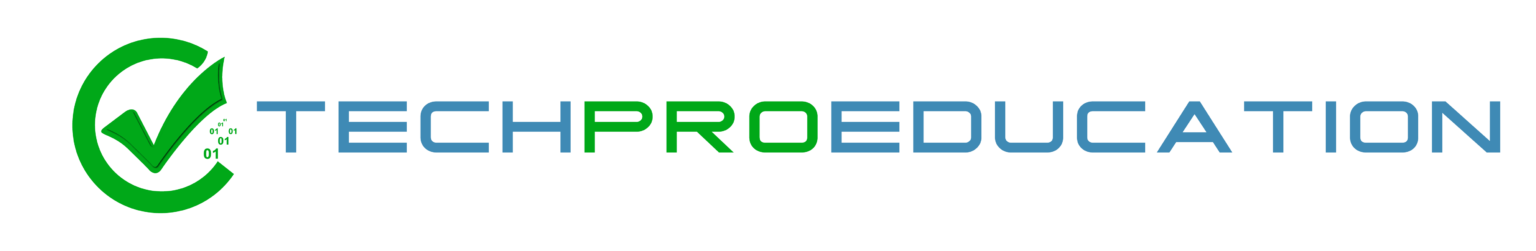

# WELCOME!

**Overview**

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

**Data Dictionary**

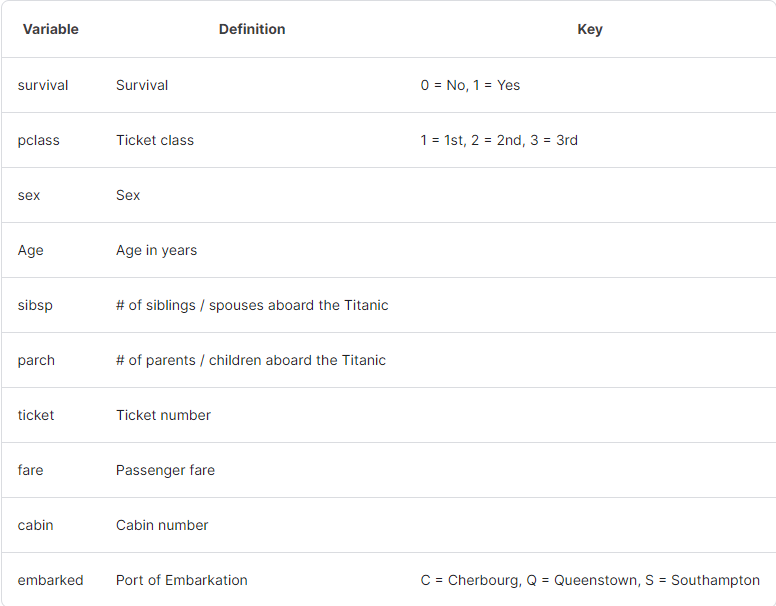

**Variable Notes**

pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

**Bu calismada train datasi analiz icin kullanilacak, test datasi nihai predictionlarda ele alinacaktir.**

# Exploratory Data Analysis and Visualization

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score, classification_report,confusion_matrix
from sklearn.metrics import  recall_score, precision_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from yellowbrick.classifier import ClassPredictionError, ROCAUC
from sklearn.pipeline  import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier

plt.rcParams["figure.figsize"] = (10,6)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [51]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [36]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Summary statistics

In [52]:
print("train:", train.shape)
print("test:", test.shape)

train: (891, 12)
test: (418, 11)


**YORUM:** train datasinda 891, test datasinda 418 gozlem var.Demek ki toplam datanin %30'u test ismina ayrilmis. 

* Burada dikkat ceken bir diger husus da train datasinda 12, test datasinda 11 sutun oldugudur. 
 
 Bunun sebebi; train datasinda yer alan hedef degisken "Survived", test datasinda yer almamaktadir. 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Handling with Null Values

In [23]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**YORUM:** Train datasinin Age sutununda 177, Cabin sutununda 687 ve Embarked sutununda 2 tane bos deger var. 

* Cabin sutununda cok fazla null deger var, bu sutunu drop etmek mantikli. 

* Ayrica object formdaki "Name" ve "Ticket" sutunlarindan bir insight beklentimiz olmadigi icin bu sutunlari da drop edebiliriz. 

In [53]:
train.drop(columns=["Cabin", "Name", "Ticket"], axis = 1, inplace = True) # axis = 1 sutun silmek istedigimiz icin 

In [8]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

* Age sutununda 177, Embarked sutununda 2 tane null deger olan satir var, bu satirlari dolduralim. 

### Embarked

Embarked (binilen liman) sutunuda var olan eksik degerleri dolduralim.

#### SimpleImputer

Basitce o sutundaki var olan verileri kullanarak eksik datalari tamamlar.

In [54]:
from sklearn.impute import SimpleImputer

simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
simple_imp.fit(train[["Embarked"]])
train[["Embarked"]] = simple_imp.fit_transform(train[["Embarked"]])

# Burada  "mean", "median", "most_frequent" gibi farklı stratejiler kullanılabilir.

In [55]:
train["Embarked"].isna().sum()

0

### Age

Age sutununda 177 tane null deger var. Burada **SimpleImputer** yontemi de kullanilabilirdi ama o yontem eksik degerleri, tum sutunun ortalamasi ile dolduracakti. 

* Oysa asagidaki listeye bakildigida yaslarin, eksik verinin yakinindaki kisilerin yas ortalamasiyla doldurulmasi daha dogru gelmistir. 

* Bu nedenle KNN Imputer kullanilmistir.

In [31]:
train["Age"]

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

#### KNNImputer

Bir siniflandirma (classification) algoritmasi olan KNN, burada eksik gozlemlerin doldurulmasinda kullanilacaktir.

Bu islemde; eksik gozlemin etrafinda (ayni sutunda, eksik gozlemin altinda ve ustunde) yer alan N tane komsu degerin agirlikli ortalamasi dikkate alinarak bir doldurma islemi yapilmaktadir. 

In [56]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors = 4, weights="uniform")

# "n_neighbors" parametresi kaç komşuyu dikkate alacağını belirler
# "weights" parametresi ağırlıkların nasıl hesaplanacağını belirler

train[["Age"]] = KNN_imputer.fit_transform(train[["Age"]])

In [57]:
train["Age"].isna().sum()

0

* Train datasinda nul deger kalmadi, ama her ihtimale karsi bir de unique degerlere bakalim, yanlis girilen yer var mi bakalim;

In [58]:
# For unique values;

def get_unique_values(df):
    
    output_data = []

    for col in df.columns:

        # If the number of unique values in the column is less than or equal to 5
        if df.loc[:, col].nunique() <= 50:
            # Get the unique values in the column
            unique_values = df.loc[:, col].unique()
            # Append the column name, number of unique values, unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        else:
            # Otherwise, append only the column name, number of unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

    output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_df

get_unique_values(train)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,PassengerId,891,-,int64
1,Survived,2,"[0, 1]",int64
2,Pclass,3,"[3, 1, 2]",int64
3,Sex,2,"[male, female]",object
4,Age,89,-,float64
5,SibSp,7,"[1, 0, 3, 4, 2, 5, 8]",int64
6,Parch,7,"[0, 1, 2, 5, 3, 4, 6]",int64
7,Fare,248,-,float64
8,Embarked,3,"[S, C, Q]",object


* Train datasinda yanlis girilis deger bulunmamakta. 

In [59]:
train.shape

(891, 9)

In [44]:
# *************** Bu icelemeleri test datasi icin de yapalim **************** 

In [60]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**YORUM:** Test datasinin Age sutununda 86, Fare sutununda 1, Cabin sutununda 
    327 tane bos deger var. 
    
* Yine Cabin sutununu drop etmek mantikli.

* Benzer sekilde analizlerde kullanilmayacak olan "Name", "Ticket" sutunlarini da dusurelim.

In [61]:
test.drop(columns=["Cabin", "Name", "Ticket"], axis = 1, inplace = True)  

In [99]:
test.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

In [62]:
# Fare sutununda null deger olan gozlemi bulalim; 

test[test["Fare"].isna()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,NaN,S


In [63]:
# Bu yolcu 3. sinifta seyahat ediyor. O halde bilet fiyati (Fare) 3. class taki yolcularin bilet fiyatlariyle ayni veya yakin olacaktir.
# Bu nedenle 3. sinifta seyahat eden yolculara bakalim;

test["Fare"][test["Pclass"]==3]

0       7.8292
1       7.0000
3       8.6625
4      12.2875
5       9.2250
        ...   
412     7.7750
413     8.0500
415     7.2500
416     8.0500
417    22.3583
Name: Fare, Length: 218, dtype: float64

In [64]:
# Bu kisilerin bilet fiyatlarinin ortalamasini alsak ve bilet fiyati bilgisi bulunmayan  1044 Id li yolcuya yazsak uygun olacak;

test["Fare"][test["Fare"].isna()] = test["Fare"][test["Pclass"]==3].mean()

In [65]:
test.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

* Artik Fare kisminda null deger kalmadi.  

* Age sutununda 86 tane null deger var. Bunlari KNN Imputer teknigini kullanarak, null degerin etrafindaki 4 kisinin ortalama yasi ile dolduralim. 

In [66]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors = 4, weights="uniform")

# "n_neighbors" parametresi kaç komşuyu dikkate alacağını belirler
# "weights" parametresi ağırlıkların nasıl hesaplanacağını belirler

test[["Age"]] = KNN_imputer.fit_transform(test[["Age"]])

In [67]:
test["Age"].isna().sum()

0

* Test datasinda nul deger kalmadi, unique degerlere de bakalim ki yanlis girilen yer var mi gorelim;

In [68]:
# For unique values;

def get_unique_values(df):
    
    output_data = []

    for col in df.columns:

        # If the number of unique values in the column is less than or equal to 5
        if df.loc[:, col].nunique() <= 50:
            # Get the unique values in the column
            unique_values = df.loc[:, col].unique()
            # Append the column name, number of unique values, unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        else:
            # Otherwise, append only the column name, number of unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

    output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_df

get_unique_values(test)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,PassengerId,418,-,int64
1,Pclass,3,"[3, 2, 1]",int64
2,Sex,2,"[male, female]",object
3,Age,80,-,float64
4,SibSp,7,"[0, 1, 2, 3, 4, 5, 8]",int64
5,Parch,8,"[0, 1, 3, 2, 4, 6, 5, 9]",int64
6,Fare,170,-,float64
7,Embarked,3,"[Q, S, C]",object


* Test data setinde yanlois girilen deger bulunmamakta, veri analize hazir.

In [69]:
test.shape

(418, 8)

## Encoding


* Veri setinde "Sex" ve "Embarked" sutunlarinda kategorik degerler yer almakta. Bu degerleri sayisal hale getirebilmek icin encoding islemi yapalim. 

* Ama hangi kategorik degiskenin ne anlama geldigini gorebilmek icin "manuel encoding" islemi  yapmayi tercih ediyoruz.

In [70]:
# Encoding for "Sex"
train["Sex"] = train['Sex'].map({"male": 0, "female": 1})# Kurtarma calismalarinda bayanlara oncelik verildigi icin onlari 1 yaptim.
train["Sex"] 

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int64

In [71]:
test["Sex"] = test['Sex'].map({"male": 0, "female": 1})
test["Sex"] 

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Sex, Length: 418, dtype: int64

In [73]:
# Benzer sekilde "Embarked" sutununu da encode yapabiliriz
# Burada gemiye binilen limanlarla ilgili ozel bir beklentimiz olmadigi icin "Ordinal Encoding" yapalim;

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() 
train['Embarked'] = encoder.fit_transform(train[['Embarked']])
test['Embarked'] = encoder.fit_transform(test[['Embarked']])


In [74]:
train['Embarked']

0      2.0
1      0.0
2      2.0
3      2.0
4      2.0
      ... 
886    2.0
887    2.0
888    2.0
889    0.0
890    1.0
Name: Embarked, Length: 891, dtype: float64

In [75]:
test['Embarked']

0      1.0
1      2.0
2      1.0
3      2.0
4      2.0
      ... 
413    2.0
414    0.0
415    2.0
416    2.0
417    0.0
Name: Embarked, Length: 418, dtype: float64

## Sutunlarin Sirasini Degistirelim

In [76]:
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2.0
1,2,1,1,1,38.0,1,0,71.2833,0.0
2,3,1,3,1,26.0,0,0,7.9250,2.0


In [77]:
# Biz genellikle target variablenin en son sutun olarak yer almasini isteriz.
# Bu bize korelasyon analizlerini daha kolay takip etme ve izleme mkani saglar. 

train = train[["PassengerId", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Survived"]]
train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.000000,1,0,7.2500,2.0,0
1,2,1,1,38.000000,1,0,71.2833,0.0,1
2,3,3,1,26.000000,0,0,7.9250,2.0,1
3,4,1,1,35.000000,1,0,53.1000,2.0,1
4,5,3,0,35.000000,0,0,8.0500,2.0,0
...,...,...,...,...,...,...,...,...,...
886,887,2,0,27.000000,0,0,13.0000,2.0,0
887,888,1,1,19.000000,0,0,30.0000,2.0,1
888,889,3,1,29.699118,1,2,23.4500,2.0,0
889,890,1,0,26.000000,0,0,30.0000,0.0,1


In [78]:
test.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1.0
1,893,3,1,47.0,1,0,7.0000,2.0
2,894,2,0,62.0,0,0,9.6875,1.0


## Copy

Artik data seti analize hazir, bu halini koruma altina alalim :)

In [79]:
# Train ve test datalarinin su anki hallerini kopyalayalim; 
train1 = train.copy()
test1 = test.copy() 

In [80]:
test=test1
train=train1

In [81]:
train.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.2500,2.0,0
1,2,1,1,38.0,1,0,71.2833,0.0,1


In [82]:
train1.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.2500,2.0,0
1,2,1,1,38.0,1,0,71.2833,0.0,1


In [80]:
test.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1.0
1,893,3,1,47.0,1,0,7.0000,2.0


In [81]:
test1.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1.0
1,893,3,1,47.0,1,0,7.0000,2.0


## Data Setinin Duzgun Halini Disa Aktaralim

Datalarin onisleme yapilmis hallerini disa aktarip yedekleyelim ki ileride direk bu satirdan calismaya baslayabilelim. 

In [83]:
# Disa aktarma;
train.to_csv("handled_train.csv", index = False)
test.to_csv("handled_test.csv", index = False)

## Data Visulation

Programi kapattigimizda yaptigimiz data visulation islemleri silinmeden kalir. Sonra her seferinde gorsellestirmeleri tekrar yaparak zaman kaybetmemek icin gorsellestirme islemlerini bu asamada yapmak istedik; 

### Destcriptive Statistics 

In [85]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,889.0,446.000000,256.998173,1.00,224.0000,446.000000,668.0,891.0000
Pclass,889.0,2.311586,0.834700,1.00,2.0000,3.000000,3.0,3.0000
Sex,889.0,0.350956,0.477538,0.00,0.0000,0.000000,1.0,1.0000
Age,889.0,29.642093,12.968346,0.42,22.0000,29.642093,35.0,80.0000
SibSp,889.0,0.524184,1.103705,0.00,0.0000,0.000000,1.0,8.0000
Parch,889.0,0.382452,0.806761,0.00,0.0000,0.000000,0.0,6.0000
Fare,889.0,32.096681,49.697504,0.00,7.8958,14.454200,31.0,512.3292
Embarked,889.0,1.535433,0.792088,0.00,1.0000,2.000000,2.0,2.0000
Survived,889.0,0.382452,0.486260,0.00,0.0000,0.000000,1.0,1.0000


**YORUM:** Fare de standart sapma mean'dan yuksek, bu sutunda outlierler oldugu degerlendirilmektedir. 

### Correlation Analysis

In [87]:
train.select_dtypes(include=['float64', "int64"]).corr()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,1.000000,-0.035330,-0.043136,0.030335,-0.057686,-0.001657,0.012703,0.013166,-0.005028
Pclass,-0.035330,1.000000,-0.127741,-0.328256,0.081656,0.016824,-0.548193,0.164681,-0.335549
Sex,-0.043136,-0.127741,1.000000,-0.089339,0.116348,0.247508,0.179958,-0.110320,0.541585
Age,0.030335,-0.328256,-0.089339,1.000000,-0.231908,-0.178013,0.088780,-0.028659,-0.074513
SibSp,-0.057686,0.081656,0.116348,-0.231908,1.000000,0.414542,0.160887,0.068900,-0.034040
Parch,-0.001657,0.016824,0.247508,-0.178013,0.414542,1.000000,0.217532,0.040449,0.083151
Fare,0.012703,-0.548193,0.179958,0.088780,0.160887,0.217532,1.000000,-0.226311,0.255290
Embarked,0.013166,0.164681,-0.110320,-0.028659,0.068900,0.040449,-0.226311,1.000000,-0.169718
Survived,-0.005028,-0.335549,0.541585,-0.074513,-0.034040,0.083151,0.255290,-0.169718,1.000000


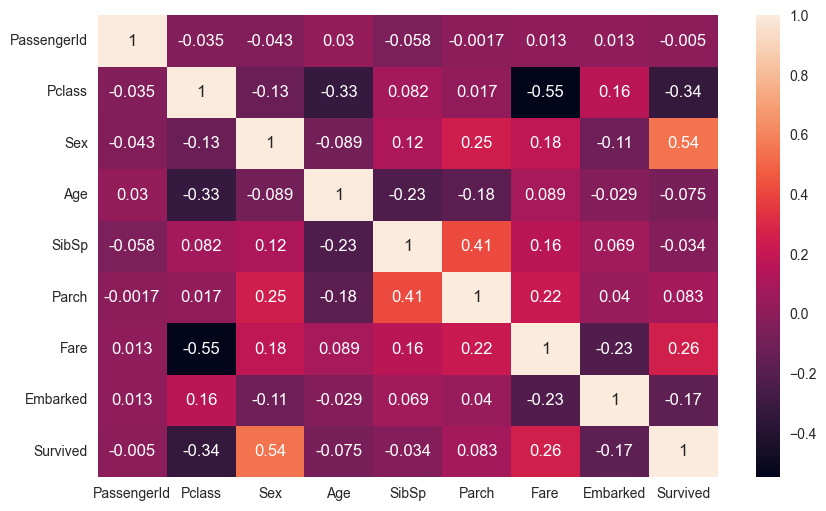

In [88]:
sns.heatmap(data=train.select_dtypes(include=['float64', "int64"]).corr(), annot=True);

**YORUM:** Veriler arasinda cok guclu korelasyonlar ve dolayisiyla multicollinearity riski  yoktur. 

### Pairplot

Analizde kullanil;an seriler arasindaki ikili iliskilieri ve serilwerin dagilimlarini gi=orebilmek icin pair plot cizelim;

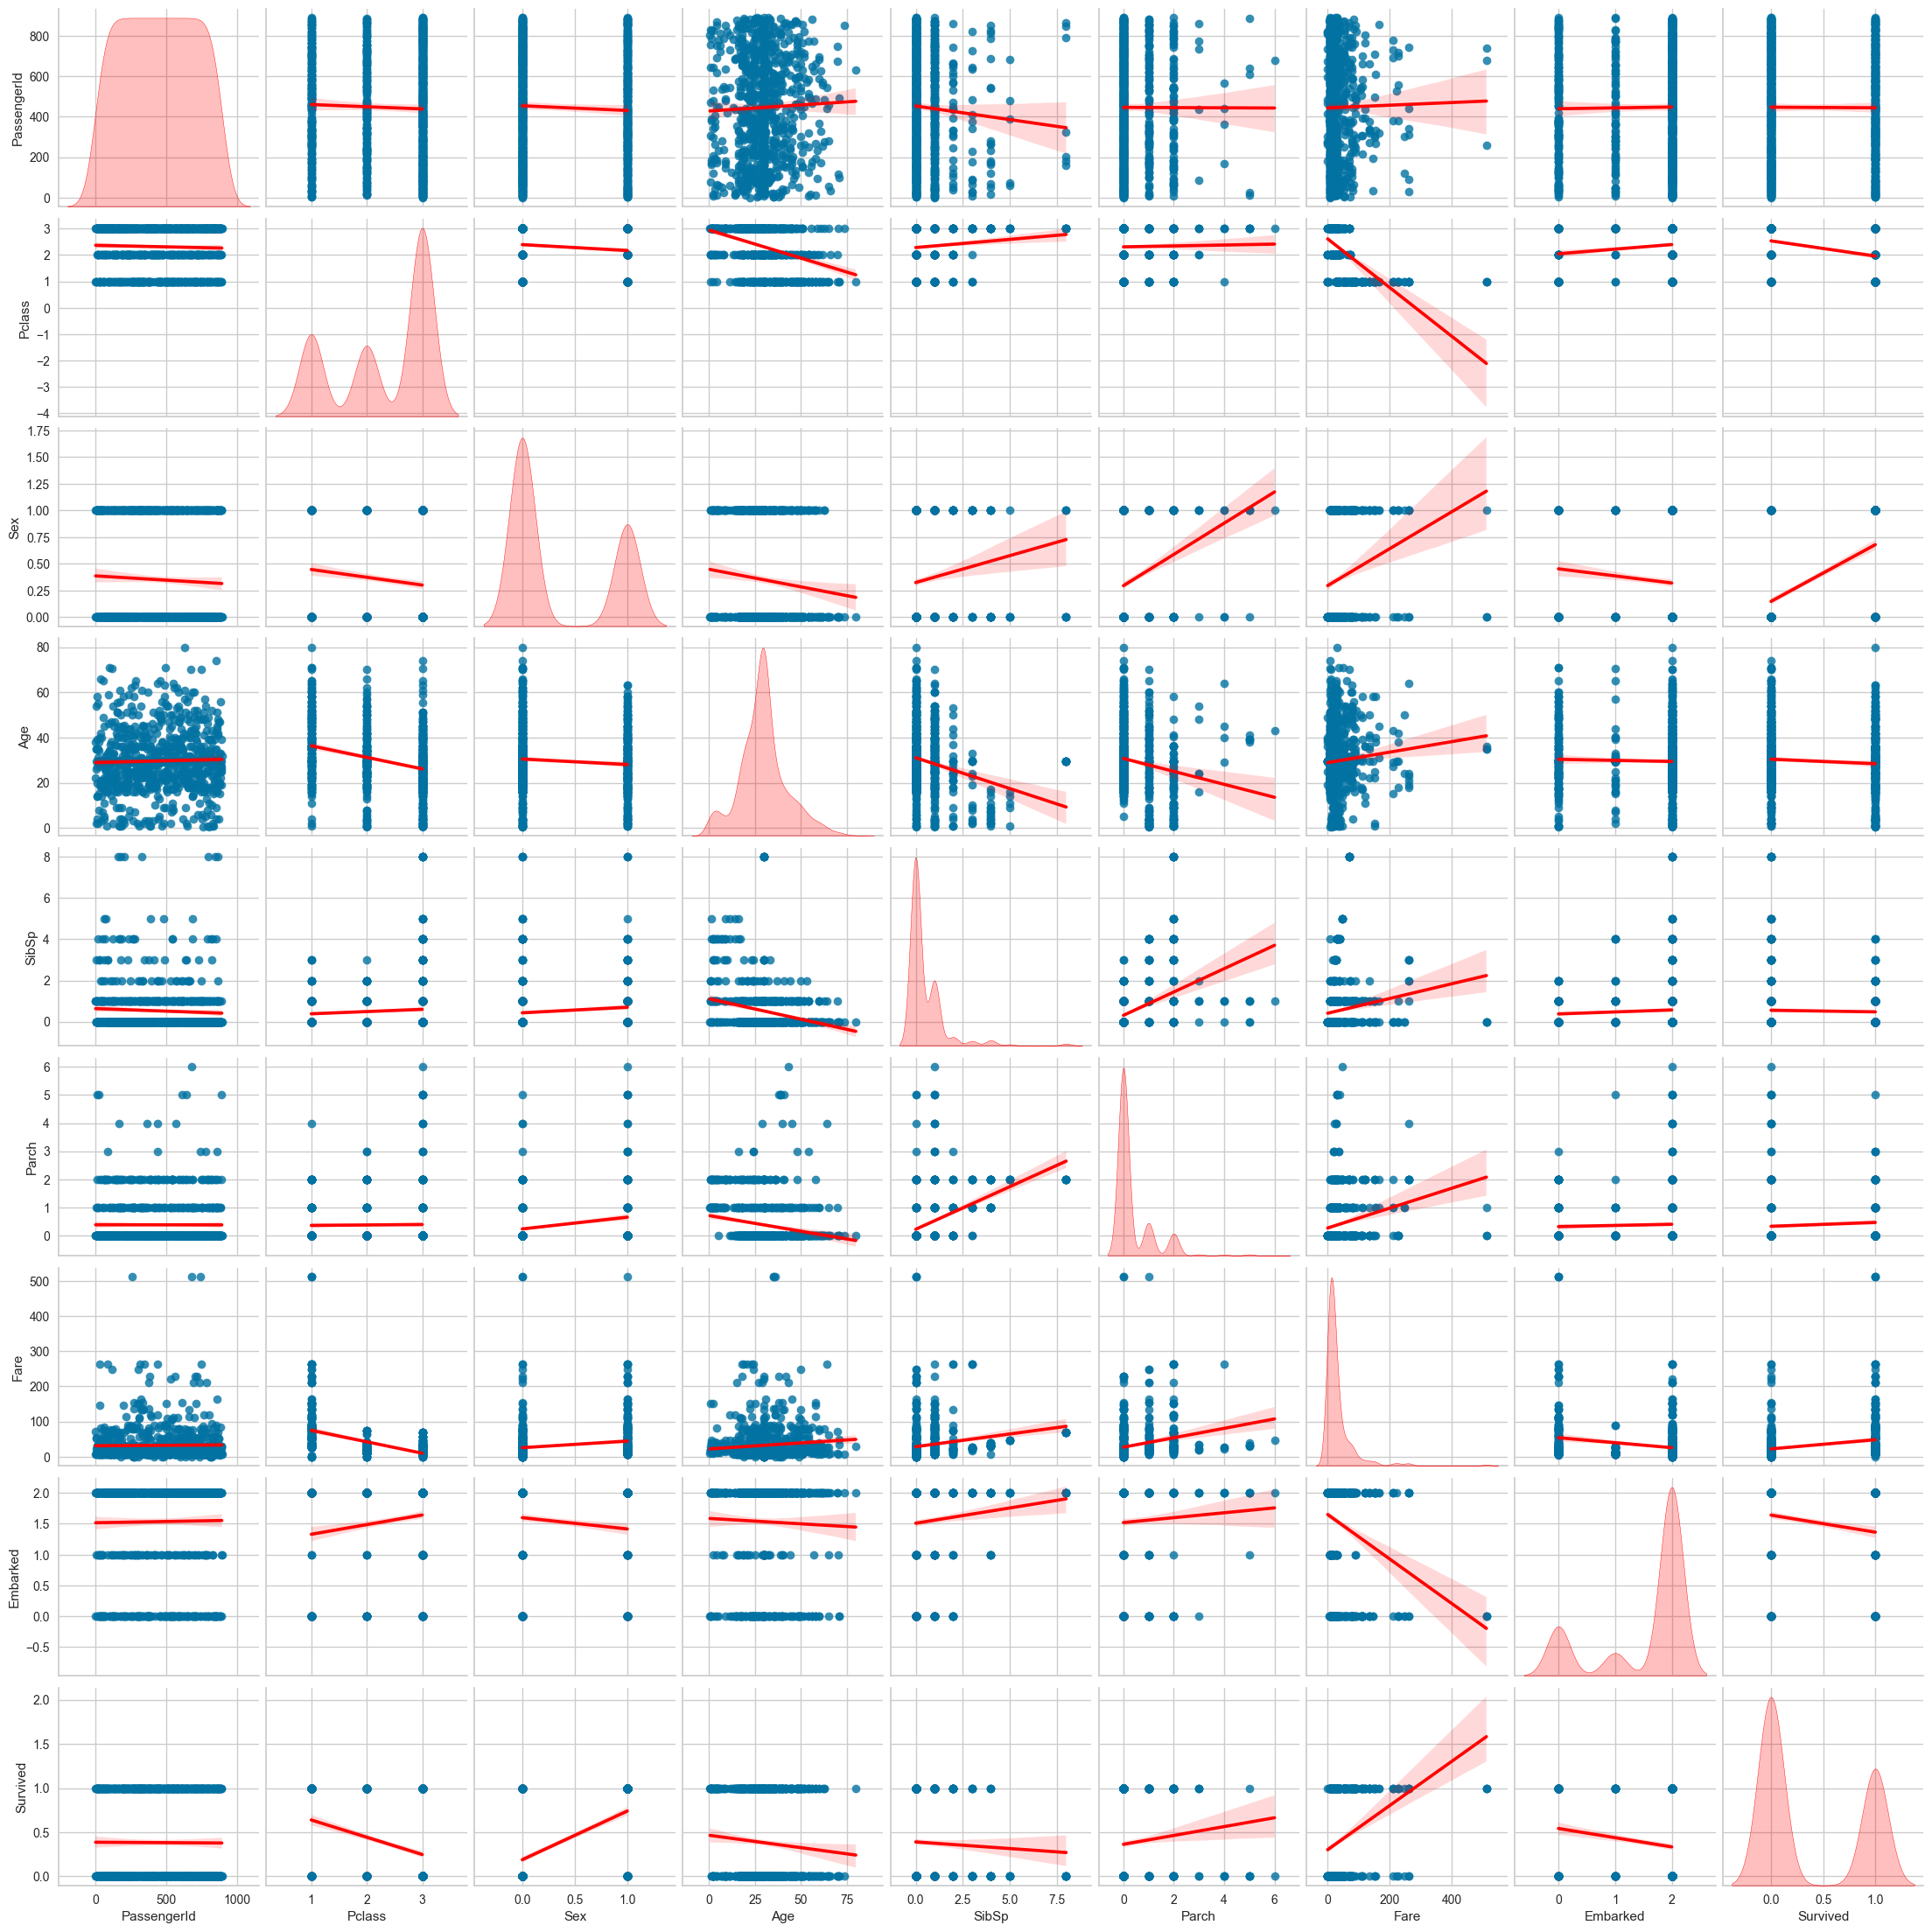

In [6]:
sns.pairplot(train, kind = "reg", diag_kind = "kde", diag_kws={"color":"red"}, plot_kws={"line_kws":{"color":"red"}});

**YORUM:** 

### Outlier Analysis by Boxplot

In [48]:
# For default settings of figures; 

plt.rcParams.update(plt.rcParamsDefault)

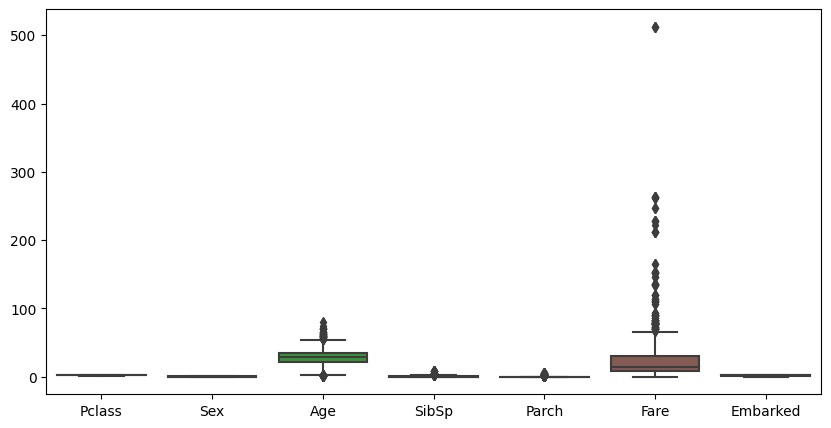

In [11]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train.drop(["PassengerId", "Survived"], axis=1))
plt.show()

* Bu grafikte bazi gfeaturelere ait bilgiler gorulememekte. Haydi bu sorunu cozelim;
* Bunun icin once **scaler**, sonra **melt** islemleri yapalim;

#### Melt 

The pd.melt() function is used to transform a wide-format data frame into a long-format data frame. The function changes the columns in the data frame so that the values of the examples are consolidated into a single column. This operation is useful for many different data processing scenarios, especially for data visualization tasks.

* **Melt**, featureleri daha genis bir alana yerlestiriyor.

* Boxplot grafigini daha **okunur hale getirerek**, Outlier analizini kolaylastiriyor.

*  **MELT**, yukaridaki **scaler islemi** ile birlikte kullanilmali. 

In [17]:
num_cols = train.columns
num_cols

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Survived'],
      dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()

num_cols = train.columns
scaled_array = scaler.fit_transform(train[num_cols[:-1]])

# let's collect standardized numeric columns in dataframe
df_dummy = pd.DataFrame(scaled_array, columns = num_cols[:-1])


# let's add the target variable
df_dummy = pd.concat([df_dummy, train.loc[:, "Survived"]], axis = 1)
df_dummy.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,-1.732505,0.825209,-0.735342,-0.589620,0.431350,-0.474326,-0.500240,0.586840,0
1,-1.728611,-1.572211,1.359911,0.644848,0.431350,-0.474326,0.788947,-1.939555,1
2,-1.724718,0.825209,1.359911,-0.281003,-0.475199,-0.474326,-0.486650,0.586840,1
3,-1.720825,-1.572211,1.359911,0.413385,0.431350,-0.474326,0.422861,0.586840,1
4,-1.716931,0.825209,-0.735342,0.413385,-0.475199,-0.474326,-0.484133,0.586840,0


In [23]:
data_melted = pd.melt(df_dummy, id_vars = "Survived", var_name = "features", value_name = "value")
data_melted

# Pivot yapmis olduk ortuk olarak

,Survived,features,value
0,0,PassengerId,-1.732505
1,1,PassengerId,-1.728611
2,1,PassengerId,-1.724718
3,1,PassengerId,-1.720825
4,0,PassengerId,-1.716931
...,...,...,...
7107,0,Embarked,0.586840
7108,1,Embarked,0.586840
7109,0,Embarked,0.586840
7110,1,Embarked,-1.939555


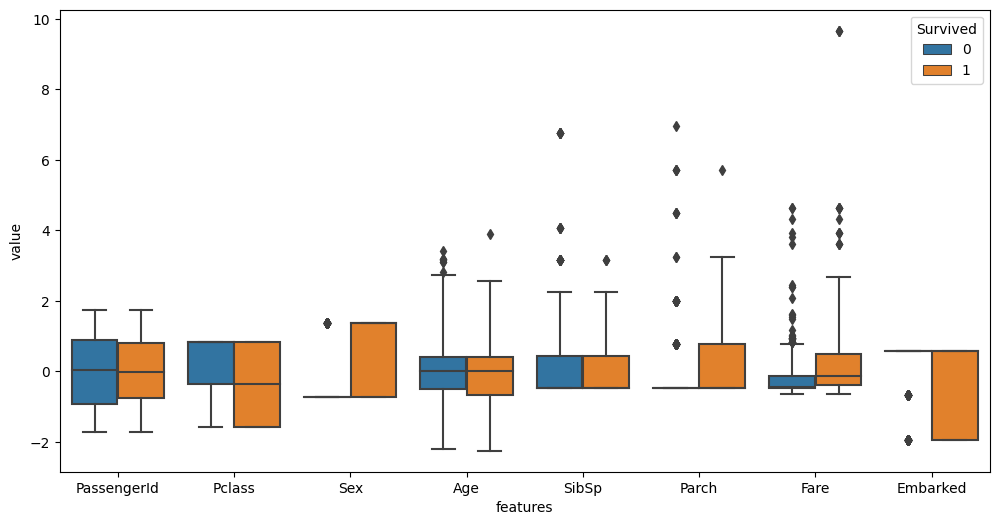

In [24]:
# box plot
plt.figure(figsize = (12,6))
sns.boxplot(x = "features", y = "value", hue = "Survived", data= data_melted, whis=2.5)
plt.show()

**YORUM:** Bazi serilerde az da olsa outlier sayilabilecek degerler bulunmakta ama bunlar gercek hayat verilerinde olabilecek durumlar oldugu icin analizden atilmayacaklardir.

### Swarm plot

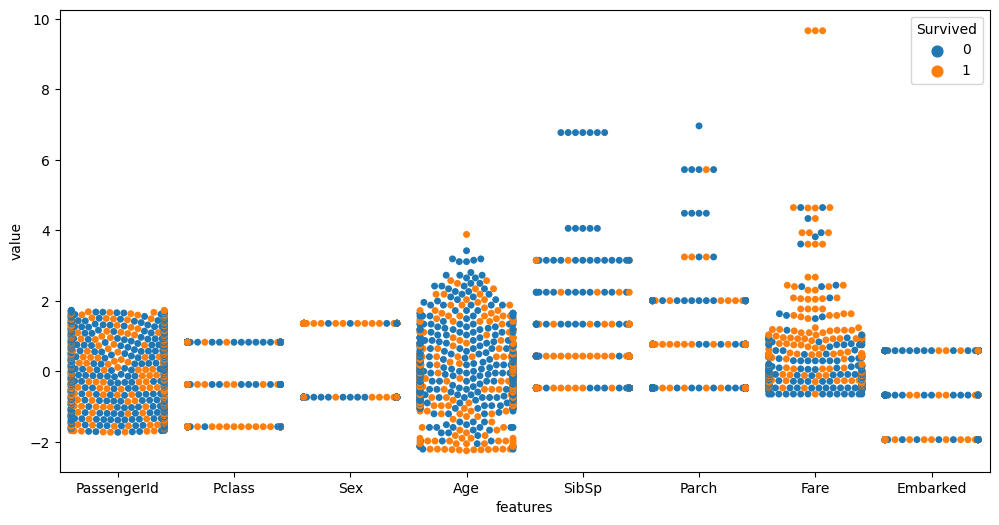

In [25]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = "features", y = "value", hue = "Survived", data= data_melted)
plt.show()

### Countplot 

Kategorik featurelerde yer alan degerlerin adetlerini, hayatta kalma durumlariyle birlikte gorebilmek icin countplot cizdirelim;

In [38]:
train.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Survived'],
      dtype='object')

In [41]:
train.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.2500,2.0,0
1,2,1,1,38.0,1,0,71.2833,0.0,1
2,3,3,1,26.0,0,0,7.9250,2.0,1
3,4,1,1,35.0,1,0,53.1000,2.0,1
4,5,3,0,35.0,0,0,8.0500,2.0,0


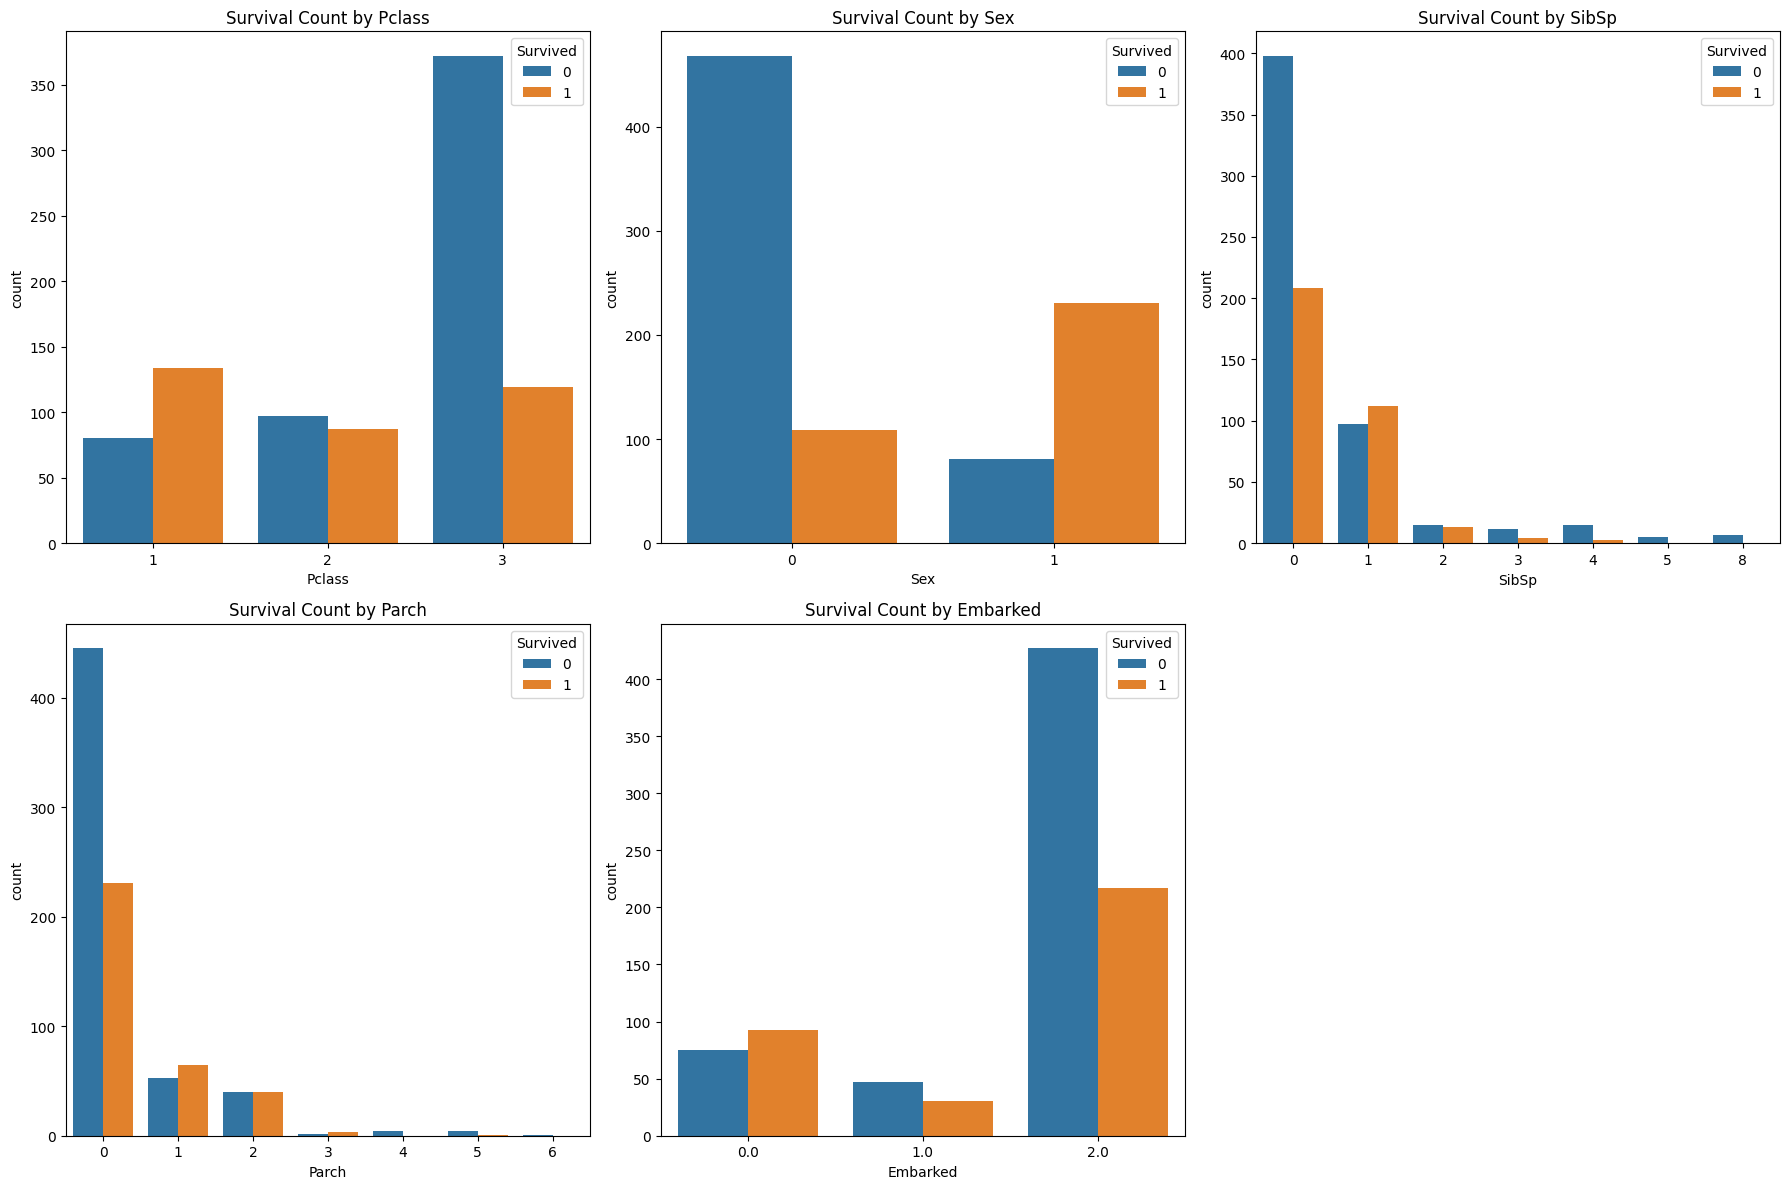

In [44]:
# Countplots for categorical features;

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

num_rows = (len(features) + 2) // 3
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 6 * num_rows))
for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    sns.countplot(data=train, x=feature, hue='Survived', ax=axes[row, col])
    axes[row, col].set_title(f'Survival Count by {feature}')
    axes[row, col].legend(title='Survived', loc='upper right')

# Boş olan subplotları gizle
for i in range(len(features), num_rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

**YORUM:**
*  1. Sinif yolcularin cogunlugu hayatta kalirken, 2. sinifta seyahat edenlerin yariya yakini, 3. siifta seyahat edenlerinse cok az bir kismi hayatta kalabilmistir. 

*  Erkeklerin az bir bolumu, kadinlarin ise buyuk cogunlugu hayatta kalabilimistir. 

*  Yalnniz seyahat edenlerde hayatta kalma daha fazladir.

*  Binilen limanlara gore; ilk limanda binenlerin cogunlugu, ikinci limanda binenlerin gorece yariya yakini ama ucuncu limanda binenlerin cok daha az bir kismi hayatta kalabilmistir. 


### Scatterplot

Numeric veriler arasindaki iliskiyi scatter plot yardimiyla inceleyeim;

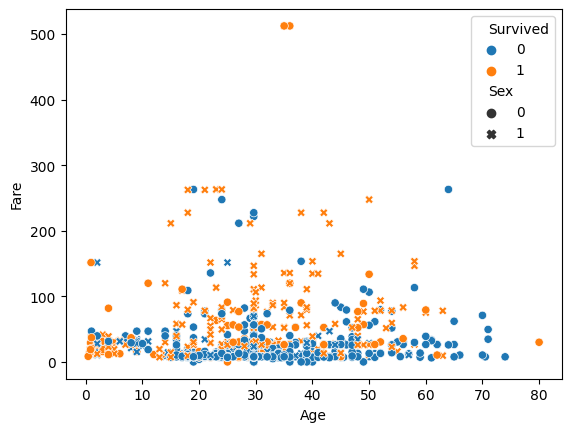

In [55]:
sns.scatterplot(data=train, x="Age", y="Fare", hue = "Survived", style = "Sex")
plt.show()

* Yuksek ucret (fare) odeyen kadin yolculardan hayatta kalanlar daha fazla olmustur. 

* Cok yuksek ucret odemis 2 tane erkek yolcu da (muhtemlen onemli is adamlaridirlar) hayatta kalmayi basarmistir. 

* Kucuk yastaki yolcularin ve kadinlarin daha fazla hayatta kaldigi gorulmektedir ki bu da gemi batarken kurtarma filikalarina bindiirlmede kadin ve cocuklara oncelik verilmesinin bir sonucudur.

## Calistirmaya Buradan Basla

In [4]:
# Disa aktarilan datayi tekrar okuma; 

train = pd.read_csv('handled_train.csv')
test = pd.read_csv('handled_test.csv')

In [85]:
train.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.2500,2.0,0
1,2,1,1,38.0,1,0,71.2833,0.0,1
2,3,3,1,26.0,0,0,7.9250,2.0,1


In [5]:
test.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1.0
1,893,3,1,47.0,1,0,7.0000,2.0
2,894,2,0,62.0,0,0,9.6875,1.0


## Labelling & Train|Test Split

Bu calismada train datasi analiz icin kullanilacak, test datasi nihai predictionlarda ele alinacaktir. 

Bu nedenle artik train datasi df gibi isleme tabi tutulacaktir. 

In [6]:
df=train # Analizde kullanacagimiz verileri' alisik oldugumuz sekilde df olarak adlandiralim;

In [7]:
df.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.2500,2.0,0
1,2,1,1,38.0,1,0,71.2833,0.0,1
2,3,3,1,26.0,0,0,7.9250,2.0,1


In [8]:
# "PassengerId" aciklayici bir bilgi icermedigi icin drop edelim;

X=df.drop(["PassengerId", "Survived"], axis=1)
y=df["Survived"]

In [9]:
X.shape

(891, 7)

In [10]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

* Veri seti dengeli (**balanced**) kabul edilebilir. 

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y , random_state = 42)
X_train.shape, X_test.shape

((712, 7), (179, 7))

# AdaBoosting Classifier

## Model Tahmini

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate

### Ilkel (Vanillia) Model

In [14]:
# Ilkel (vanillia) AdaBoosting modelini, default parametrelerle tahmin edelim; 
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

In [15]:
# Modeli fit edelim;
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=42)

In [16]:
y_train_pred = ada_model.predict(X_train)
y_train_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,

In [17]:
y_pred = ada_model.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0], dtype=int64)

### Modelin Sorlarini Degerlendirme

Tahmin ettigimiz ilkel modelin skorlarina bakalim.

In [18]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    
eval_metric(ada_model, X_train, y_train, X_test, y_test)

Test_Set
[[90 20]
 [21 48]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       110
           1       0.71      0.70      0.70        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


Train_Set
[[391  48]
 [ 64 209]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       439
           1       0.81      0.77      0.79       273

    accuracy                           0.84       712
   macro avg       0.84      0.83      0.83       712
weighted avg       0.84      0.84      0.84       712



* Ilkel model test datasinda 57 tane hata yapmis. 
* Accuracy trainde 0.85 iken testte 0.79'a dusmus. 
* Modelde overfitting sorunu olup olmadigini anlayabilmek icin cross validation yapalim;

### Cross Validation for Vanillia Model

In [122]:
from sklearn.model_selection import cross_val_score, cross_validate

model = AdaBoostClassifier(n_estimators=50, random_state=42) 

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.815335
test_precision    0.782179
test_recall       0.732971
test_f1           0.751100
dtype: float64

* CV sonrasi accuracy 0.81'e indi (demek ki modelimizin (train datasinin)) gercek accuracy degeri 0.81 imis. 
* Bu deger test datasinin accuracy degeriyle uyumlu oldugu icin modelde overfit sorunu yoktur. 

### Default Degerlerle Agaci cizdirelim

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
model = AdaBoostClassifier(n_estimators=50, random_state=42) 
model.fit(X_train,y_train)

In [ ]:
%matplotlib inline  
# grf cizmezse bunu calistir. 

In [ ]:
features = list(X.columns)
targets = df["Survived"].astype("str") #Target "numeric" ise "string" e çevir, yoksa hata alırsın
plt.figure(figsize=(16,10),dpi=150)
plot_tree(model.estimators_[2], filled=True, feature_names=X.columns, class_names=targets.unique());

In [ ]:
df.sample(1)

**YORUM:** Vanillia modele gore bu ornek (yolcu); bilet fiyati (Fare) 13.5 oldugu icin 0 classina dusecektir yani hayatta kalmamistir.   

## GridSearch for Ada Boosting

Modelin optimal hyper parametrelerini bulabilmek icin GridSearchCV yontemini kullanalim.

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
model = AdaBoostClassifier(random_state=42)

In [21]:
param_grid = {"n_estimators": [20, 30, 100, 200], "learning_rate": [0.01, 0.1, 0.2, 0.5, 1.0]}

In [22]:
ada_grid_model = GridSearchCV(model, param_grid, cv=5, scoring= 'accuracy')

In [23]:
ada_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [20, 30, 100, 200]},
             scoring='accuracy')

In [24]:
ada_grid_model.best_params_

{'learning_rate': 0.2, 'n_estimators': 100}

In [25]:
# Bu modelin accuracy skoru;
ada_grid_model.best_score_

0.8146853146853147

* AdaBoost'ta accuracy skoru 0.80 oldu.

### Gridsearch ile Elde Ettigimiz Hyper Parametreleri Kullanarak AdaBoost Modelini Tahmin Edelim

In [26]:
tuned_preds = ada_grid_model.predict(X_test) 
tuned_preds

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0], dtype=int64)

* Bu sonuclar Grid search yontemiyle elde ettigimiz best hyper paramereler kullanilarak tahmin edilmis oldu. 

In [27]:
# GridSearch sonrasi elde ettigimiz sonulari daha detayli gormek istersek; 

y_pred = ada_grid_model.predict(X_test)

eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[93 17]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179


Train_Set
[[377  62]
 [ 64 209]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       439
           1       0.77      0.77      0.77       273

    accuracy                           0.82       712
   macro avg       0.81      0.81      0.81       712
weighted avg       0.82      0.82      0.82       712



## Feature Importances in ADA Boost

In [ ]:
model = AdaBoostClassifier(
                          n_estimators=100, 
                          learning_rate=0.2, 
                          random_state=42)

"""
Ada Grid Search best paramereleri bunlar;
{'learning_rate': 0.2, 'n_estimators': 100}

"""

model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(index=X.columns, data= model.feature_importances_, columns=['ada_importance'])
ada_imp_feats = feats.sort_values("ada_importance")
ada_imp_feats

In [ ]:
# Bu sonuclari gorellestirelim; 
plt.figure(figsize=(12,6))
sns.barplot(data=ada_imp_feats ,x=ada_imp_feats.index, y='ada_importance')

plt.xticks(rotation=90);

**YORUM:** Ada Boost sonucuna gore Titanik'ten kurtulanlarin en onemli ozellikleri; yas, bilet fiyari, aile birey sayisi ve cinsiyetleri olmustur. 

* Burada **yas**; gemiden tahliyede cocuk ve yaslilara oncelik verilmis olmasi yonuyle, **bilet fiyatlari**; yolculuk yapilan sinifi ve tahliye islemlerinde bu siniflara gore kisilere oncelik verilmis olmasina, **aile birey sayisi**; kisilerin ailelerini kurtarmaya daha oncelik vermis olmalariyla, **cinsiyet** ise tahliyede kadinlara oncelik verilmis olmasiyla iliskilidir. 

### Evaluating ROC Curves and AUC

Bu skorlar modelin GENEL PERFORMANSINI gosterir.

In [ ]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score

In [ ]:
plot_roc_curve(ada_grid_model, X_test, y_test);

* AUC skoru 0.84'tur. Bu skorun 1'e yakin olmasi modelin genel perfortmansinin iyi oldugunu gostermektedir. Bu durumda; AdaBoost yontemi de  oldukca basarilidir. 

# Gradient Boosting Classifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

## Ilkel (Vanillia) Model

In [29]:
grad_model = GradientBoostingClassifier(random_state=42)

In [30]:
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [31]:
eval_metric(grad_model, X_train, y_train, X_test, y_test) # ilkel model bu

Test_Set
[[98 12]
 [24 45]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179


Train_Set
[[420  19]
 [ 47 226]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       439
           1       0.92      0.83      0.87       273

    accuracy                           0.91       712
   macro avg       0.91      0.89      0.90       712
weighted avg       0.91      0.91      0.91       712



**YORUM:** Model 55 tane gozlemde hatali tahmin yapmistir. Accuracy degeri trainde0.91 iken testte 0.79'a dusmus olup, aradaki farkin yuksekligi overfit endisesine sebep olmaktadir.

Bir CV yaparak bunu netlestirelim; 

## Cross Validation for Vanillia Model

In [136]:
model = GradientBoostingClassifier(random_state=42) 

# icinde subsample=1.0 var. Buna 0.6, 0.8 de verilebiliyor. 
# max_depth = 3 default olarak ama sen burada 2 yi de dene her zaman. Overfiti onlersin. 3'u gecme kesinlikle. 
# max_feature Log2(feature sayisi), karekok(feature sayisi), auto, .. var. 
# Gredient Boosting linear ve logistic Regresyonun en iyi yonlerini alarak calisir.   

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1', 'roc_auc'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.825064
test_precision    0.826166
test_recall       0.699094
test_f1           0.753091
test_roc_auc      0.859908
dtype: float64

* CV sonucunda train datasina ait accuracy degeri 0.82'ye dusmus olup, test datasinin accuracy degeri olan 0.81 ile aralarindaki fark azalmistir. 

* O halde modelde overfit yoktur.

## Gridsearch for Gradient Boosting

In [52]:
param_grid = {"n_estimators":[20, 50, 100, 200],
              "learning_rate": [0.001, 0.01, 0.1], 
              "max_depth": [3, 4, 5, 6],
              "subsample": [0.5, 1], 
              "max_features" : [None, 2, 3, 4]
             } 

In [53]:
gb_model = GradientBoostingClassifier(random_state=42)

In [54]:
grid = GridSearchCV(gb_model, param_grid, scoring = "accuracy", verbose=2, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


In [35]:
grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 2,
 'n_estimators': 100,
 'subsample': 0.5}

In [55]:
grid.best_score_ # accuracy skoru bu

0.8343642273219738

* Gradient Boosting'de accuracy skoru 0.84'e yukseldi.

### Gridsearch ile Elde Ettigimiz Hyper Parametreleri Kullanarak GradientBoost Modelini Tahmin Edelim

In [56]:
y_pred = grid.predict(X_test)

eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[104   6]
 [ 29  40]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.87      0.58      0.70        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.78       179
weighted avg       0.82      0.80      0.79       179


Train_Set
[[426  13]
 [ 87 186]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       439
           1       0.93      0.68      0.79       273

    accuracy                           0.86       712
   macro avg       0.88      0.83      0.84       712
weighted avg       0.87      0.86      0.85       712



**YORUM:** GridSearch sonrasi modelin hatasi 55'ten 46'ya dustu, accuracy skoru da 0.83'e yukseldi. 

### Feature importances

In [ ]:
model = GradientBoostingClassifier(
                                  learning_rate = 0.01, 
                                  max_depth = 5,
                                  max_features = 4,
                                  n_estimators = 200,
                                 subsample = 1, 
                                  random_state = 42)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance")
grad_imp_feats

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=grad_imp_feats, x=grad_imp_feats.index, y='grad_importance')

plt.xticks(rotation=90)
plt.show()

* Bu grafige gore; Titanic batarken hayatta kalanlarin en onemli ozellikleri; **cinsiyetleri** (kadinlara oncelik verilmis olmasi),  **biletlerinin fiyati** (yolculuk yaptiklari sinif, gemi batarken filikalara once firstclass yolculari bindirilmis, 3. sinif yolcular filikalara saldirmasinlar diye onlarin bulundugu bolumlerin kapilari diaridan i=kilitleinmistir), **yas** (cocuklara oncelik verilmis olmasi, zengin yasli kisilerin de ilk tahliye edilenler arasinda yer almasi vb) ve bilet fiyatlariyla uyumlu olarak **yolculuk siniflari** (passenger class) olmustur. 

## Evaluating ROC Curves and AUC

In [ ]:
plot_roc_curve(grid, X_test, y_test);

* AUC skoru 0.84 cikmis olup, gorece yuksetir.

In [ ]:
plot_precision_recall_curve(grid, X_test, y_test);

* Gridsearch ile belirlenen best hyper parametrelerle tahmin edilen Gradient Boosting modelinin PRC skoru 0.83'tur. Veri seti balance kabul edildigi icin bu skora bakmak sart degildir. 

# XGBoosting Classifier

In [38]:
from xgboost import XGBClassifier

## Ilkel (Vanillia) Model for XGBoost

In [39]:
xgb = XGBClassifier(random_state=42).fit(X_train, y_train)

In [40]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[93 17]
 [19 50]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Train_Set
[[433   6]
 [ 14 259]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       439
           1       0.98      0.95      0.96       273

    accuracy                           0.97       712
   macro avg       0.97      0.97      0.97       712
weighted avg       0.97      0.97      0.97       712



**YORUM:** Modelin hatasi 58, accuracy skoru 0.78 olup, Gradient Boosting ve Ada Boost'un ilkel modelerine gore XGBoost'un ilkel modeli daha basarilidir. 

Yine train kisminda acuracy  yuksek (0.97), test kisminda dusuk (0.78) oldugu icin overfit edisesi vardir. Bunu CV ile kontrol edelim; 

In [41]:
model = XGBClassifier(random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1', 'roc_auc'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.793564
test_precision    0.740373
test_recall       0.714683
test_f1           0.722914
test_roc_auc      0.862850
dtype: float64

* CV sonrasi train datasina ait accuracy degerinin 0.80 oldugu gorulmekte olup, test kisminin accuracy degeriyle (0.78) gayet uyumludur. Modelde overfit yoktur.

## Gridsearch for XGBoost

In [42]:
param_grid = {"n_estimators":[50, 100, 200],'max_depth':[3,4,5], "learning_rate": [0.1, 0.2],
             "subsample":[0.5, 0.8, 1], "colsample_bytree":[0.5,0.7, 1]}

# Buradaki hyprparametreler yeterli olur. 

In [43]:
xgb_model = XGBClassifier(random_state=42)

In [44]:
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "accuracy", verbose=2, n_jobs = -1).fit(X_train, y_train)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [45]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 4,
 'n_estimators': 50,
 'subsample': 0.5}

In [47]:
xgb_grid.best_score_

0.8343543780163498

* Modelin accuracy skoru 0.84'e kadar yukseldi XGBosost'ta. 

### GridSearch ile Elde Ettigimiz Hyper Parametreleri Kullanarak XGBoost Modelini Tahmin Edelim

In [48]:
y_pred = xgb_grid.predict(X_test)

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[96 14]
 [23 46]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179


Train_Set
[[418  21]
 [ 58 215]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       439
           1       0.91      0.79      0.84       273

    accuracy                           0.89       712
   macro avg       0.89      0.87      0.88       712
weighted avg       0.89      0.89      0.89       712



**YORUM:**  

* Modelin hatalari 55 oldu. Bu deger Gredient Boost un ilkel modelinde 51 idi. Accuracy degeri de Gredient Boost'ta 0.81 iken burada 0.79'a dustu.  O halde **en basarili** sonuclari ureten model **GridSearch Gradient Boost** olmustur. 

### Feature Importances in XGBoost

In [ ]:
model = XGBClassifier(
                      random_state=42, 
                      colsample_bytree = 0.7, 
                      learning_rate = 0.1,
                      max_depth = 4,
                      n_estimators = 100,
                      subsample= 0.5
                      )

""" Bu degerleri GreaSearch sonucundan aldim 
{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'subsample': 0.5} """

model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance")
xgb_imp_feats

In [ ]:
#Bu sonuclari gorselletirelim; 

sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index,y='xgb_importance')

plt.xticks(rotation=90);

**YORUM:** Bu grafige gore; Titanic batarken hayatta kalanlarin en onemli ozellikleri; cinsiyetleri, yolculuk siniflari ve biletlerinin fiyati olmustur.

### Feature Importance Comparison

In [ ]:
pd.concat([ada_imp_feats, grad_imp_feats, xgb_imp_feats], axis=1)

**YORUM:** Bu tabloya gore AdaBoost'ta en onemli feature yas (Age) iken, Gradient Boost ve XGBoost'ta cinsiyet one cikmistir. 

# PREDICTION FOR NEW OBSERVATIONS

Elimizdeki en iyi model, Vanillia Gradient Boost (grad_model) modelidir. Simdi bu modeli kullanarak, daha once modelin gormemis oldugu ikinci (test adiyla bize verilen) gozlemler icin predict alalim. 

## Datalari Yeniden Cagiralim ve Duzenleyelim

In [58]:
new = pd.read_csv('handled_test.csv')
new.shape 

(418, 8)

In [59]:
# Disa aktarilan datayi tekrar okuma; 

df_dedigim = pd.read_csv('handled_train.csv')
new = pd.read_csv('handled_test.csv')

In [60]:
df_dedigim.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,0,22.0,1,0,7.25,2.0,0


In [61]:
new.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1.0


**ACIKLAMA:** df dedigim datadan PassengerID yi drop etmis oldugum icin, new datadan da bu sutunu dusurelim ki analizde kullandimizi datanin sekli ile yeni verecegimiz datanin sekli uyumlu olsun. (Ilk denemede buu yapmadigim icin hata aldim).

In [62]:
# X=df.drop(["PassengerId", "Survived"], axis=1)  bole yapmistim yukarida
X.head(1)   # X dedigim ve analiizlerde kullandigim data bu formda

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.25,2.0


In [63]:
new = new.drop(["PassengerId"], axis=1)
new.head(1)   # new data da analizde kullandigim datayla ayni forma geldi.

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1.0


## Predict Time

In [65]:
new.pred = grid.predict(new)
new.pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Sonuclari Disa Aktaralim

In [66]:
# Prediction sonuclarini csv olarak disa aktarabilmemiz icin DataFrame e donusturmemiz gerekiyor;

final = pd.DataFrame(new.pred)
final.head(10)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,1
9,0


In [67]:
# final adli bu sonuclari csv dosyasina aktarakim (disa cikaralim)

final.to_csv("final.csv", index = False)

Kaggle yukledim. **Basari skoru 0.76315** cikti. 

# CONCLUSSION

Bu calismada;  15 Nisan 1912'de batan ve 2224 yolcu ve murettebatindan 1502'si yasamini yitiren Titanic yolcu gemisindeki kisilerden 1309'unun bilgileri kulanilarak, Machine Learning analizleri gerceklestirilmistir. Bu verilerden 891'i analizlerde kullanilmis, 418'inin hayatta kalip kalmadiklari, elde edlien model kullanilarak tahmin edilmeye calisilmistir. 

891 kisilik veri on isleme sureclerinden gecirildikten sonra kendi icinde 713 tanesi (%80'i) train, 178 tanesi (%20'si) test datasi olarak ayrilmistir. 

Calismada Ensamble (zayif ogrenicilere dayali) analiz tekniklerinden boosting (birbirinin hatasini ogrenerek, o hatayi azaltma ve boylece daha basarli tahminler yapma) yontemlerinden AdaBoost, GradientBoost ve XGBoost yontemleri kullanilmistir. Modeller hem deafult parametreleri kullanilarak hem de GridSearch yontemile elde edilen optimal hyper parametreler kulanilarak tahmin edilmistir. Bu analizler sonucunda elde edilen skorlar asagidaki gibidir;     

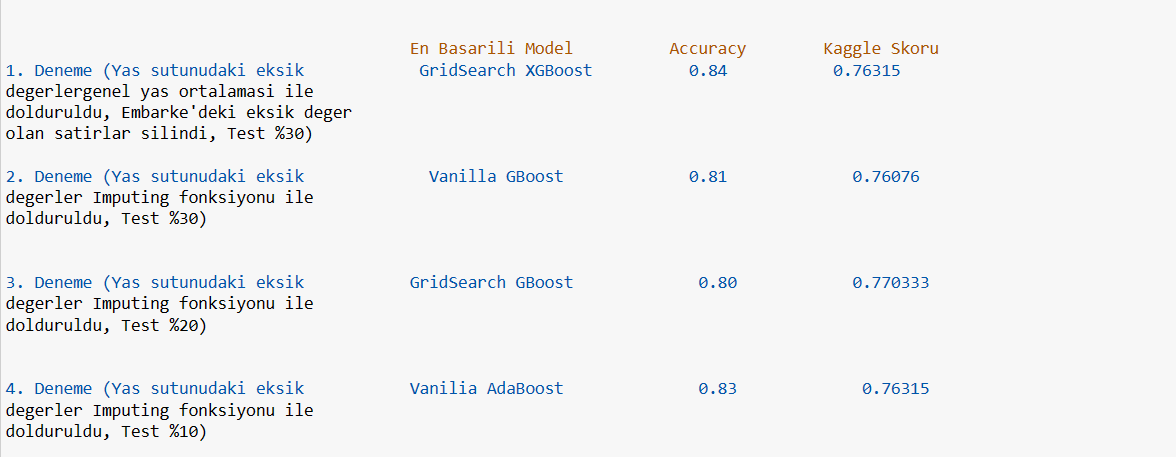

Bu sonuclara gore en basarili skorlarin; GridSearch yontemile elde edilen optimal hyper parametreler kulanilarak tahmin edilen Gradient Boost yontemide alindigi gorulmustur. Bu modelde accuracy = 0.80,  f1 = 0.86 / 0.70 bulunmustur.

Ulasilan bu model kullanilarak, en basta ayri tutulan (sadece veri on isleme sureclerine tabi tutularak analizde kullanilan data ile benzer forma getirilmis bulunan) 418 gozlem icin tahmin (prediction) yapilmistir. Ulasilan prediction sonuclari Kaggle'e yuklenmis ve **0.77033** skor alinmistir.


In [ ]:
# The End